In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[10.06376669  9.63391276  9.39582886  9.22513415  8.81750957  8.32179518
  7.83460912  7.85188512  7.54667311  7.48145039  7.11961375  6.99227252
  6.58293248  6.39531078  6.04660235  5.69082375  5.48378291  5.217612
  4.99342317  4.73428717  4.51302559  4.35228676  4.11629688  3.88418267
  3.55573832  3.50006786  3.41128641  3.25844672  3.04274136  2.94558568
  2.84015405  2.73372914  2.58696734  2.42038737  2.24910538  2.26218921
  2.120283    2.01078965  2.06121323  1.98128115  1.94598947  1.87480666
  1.81104942  1.72455791  1.69099823  1.61511609  1.5833193   1.43808901
  1.50727403  1.43788038  1.38573987  1.36747943  1.26581002  1.2495099
  1.2437343   1.25383412  1.22371361  1.18003178  1.12343224  1.17349904
  1.11860404  1.10021589  1.06719258  0.96709617  0.99673216  1.00965341
  1.00919522  0.93829633  0.97626841  0.90657322  0.86890736  0.81357237
  0.75714926  0.77142725  0.79693162  0.72143953  0.77942286  0.6609652 ]
[2.34  2.265 2.28  2.37  2.345 2.235 2.17  2.23  2.23

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_29598/1430441265.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     537     0:01.6
2     1026    0:02.9
3     1461    0:04.0
20    8679    0:23.8
40    14601   0:41.2
60    20430   0:58.3
80    26241   1:15.2
100   32178   1:32.8
120   38325   1:50.8
140   44412   2:08.7
160   50241   2:25.7
180   56088   2:42.7
200   61974   3:00.0
220   67950   3:17.5
240   73872   3:34.8
260   79848   3:52.5
280   85611   4:09.3
300   91536   4:26.7
320   97404   4:43.7
340   103311   5:00.9
360   109410   5:18.8
380   115185   5:35.7
400   121302   5:53.5
420   127119   6:10.5
440   133176   6:28.2
460   139068   6:45.4
480   145014   7:02.8
500   150984   7:20.2
520   156822   7:37.3
540   162738   7:54.6
560   168690   8:12.0
580   174567   8:29.1
600   180618   8:46.7
620   186489   9:03.9
640   192294   9:20.8
660   198012   9:37.4
680   203982   9:55.2
700   209547  10:12.0
720   215658  10:29.9
740   221502  10:47.0
760   227466  11

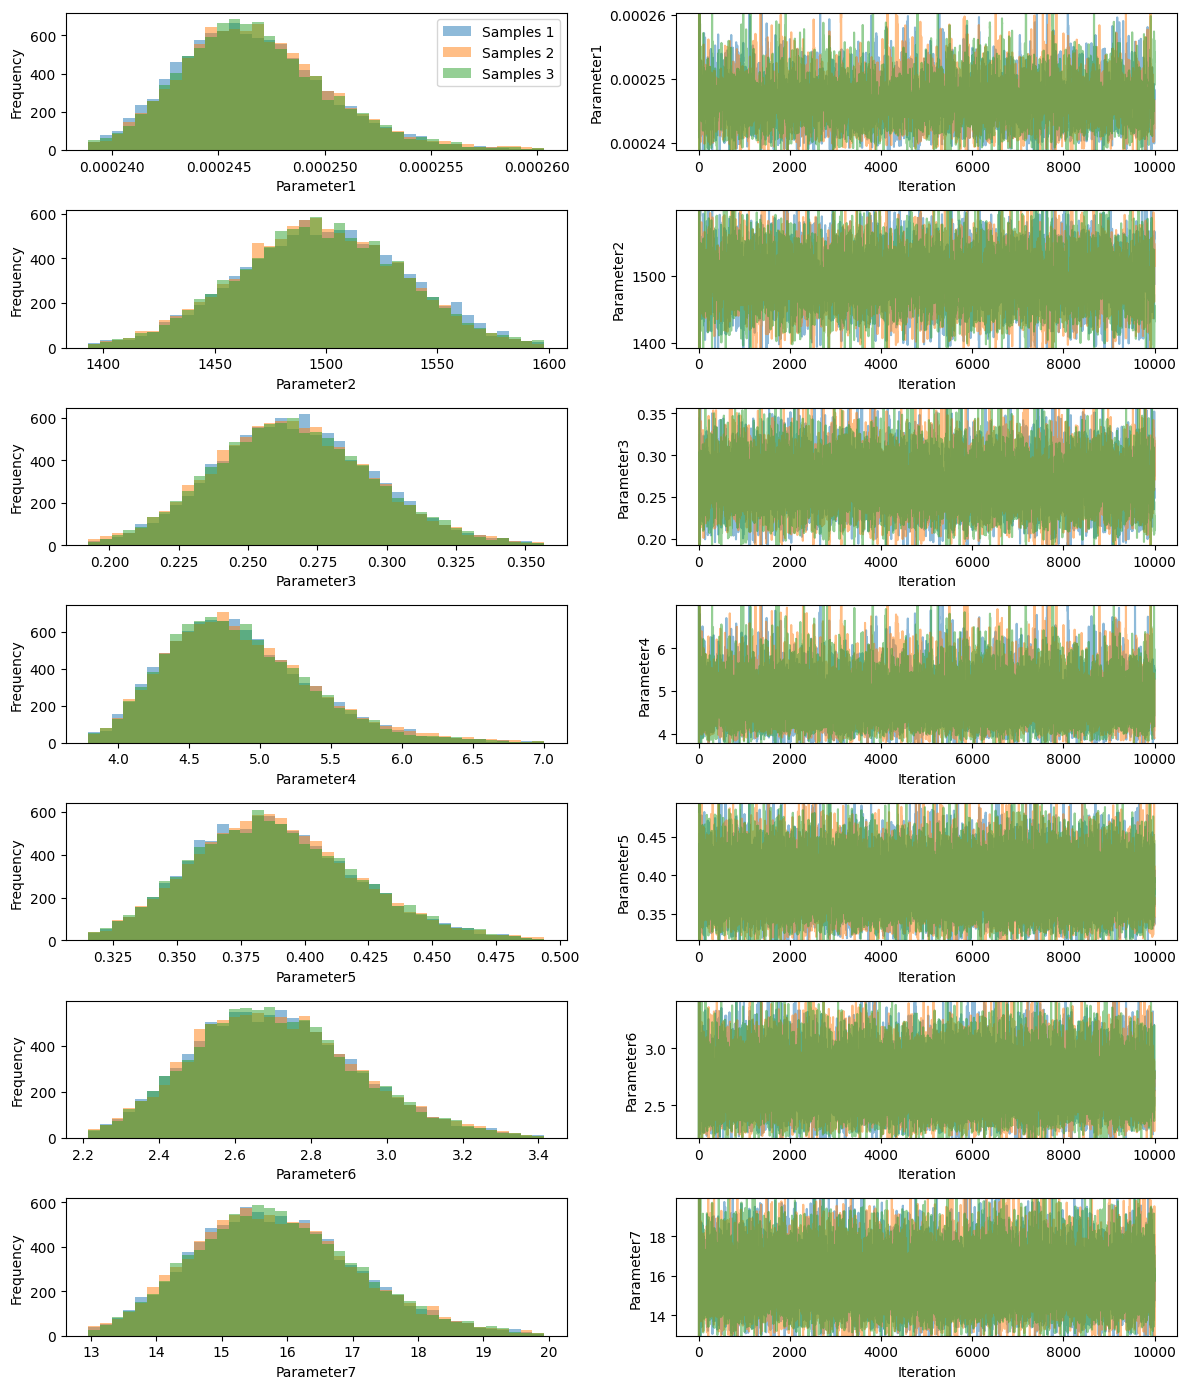

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [17]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 7)
[2.40508154e-04 1.53073316e+03 2.96225092e-01 4.73315712e+00
 3.90748058e-01 2.47440016e+00 1.39000261e+01]
[[2.40508154e-04 1.53073316e+03 2.96225092e-01 ... 3.90748058e-01
  2.47440016e+00 1.39000261e+01]
 [2.38689837e-04 1.59285174e+03 3.08442551e-01 ... 4.18789044e-01
  2.85178954e+00 1.76872132e+01]
 [2.38666044e-04 1.56584098e+03 3.23528906e-01 ... 3.70219282e-01
  2.76869782e+00 1.63106335e+01]
 ...
 [2.48307232e-04 1.51653120e+03 2.52551890e-01 ... 4.06699503e-01
  2.80612256e+00 1.52325108e+01]
 [2.47287620e-04 1.52745861e+03 2.48346908e-01 ... 3.36466123e-01
  2.62756149e+00 1.47305731e+01]
 [2.46811830e-04 1.48810767e+03 2.59638586e-01 ... 3.44969655e-01
  2.72312514e+00 1.74775239e+01]]


In [18]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


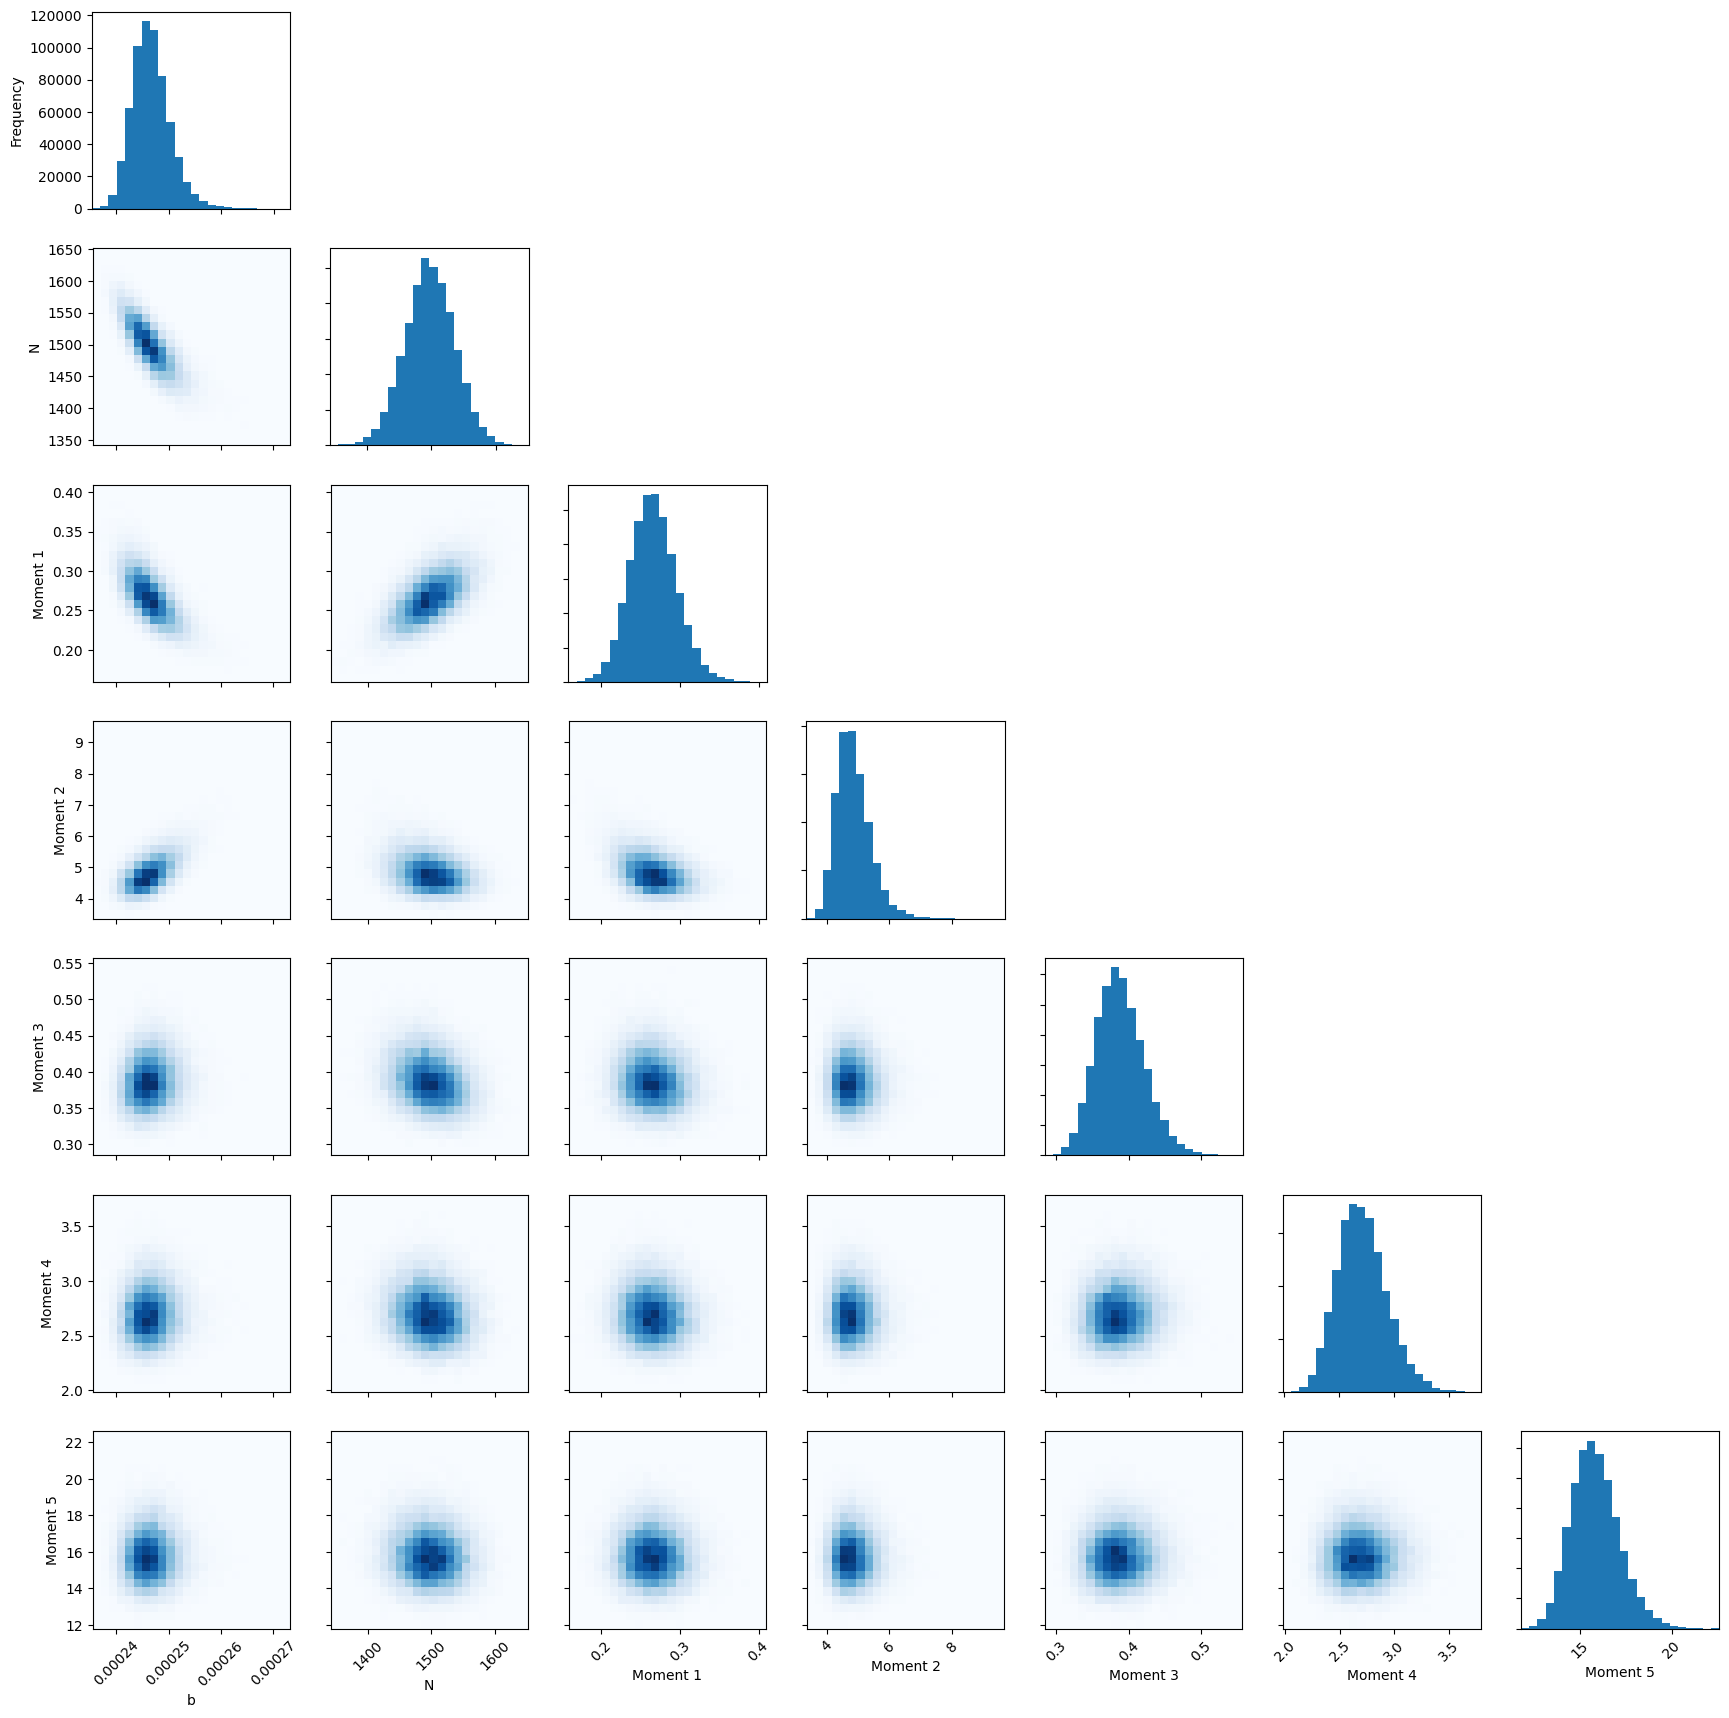

In [19]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

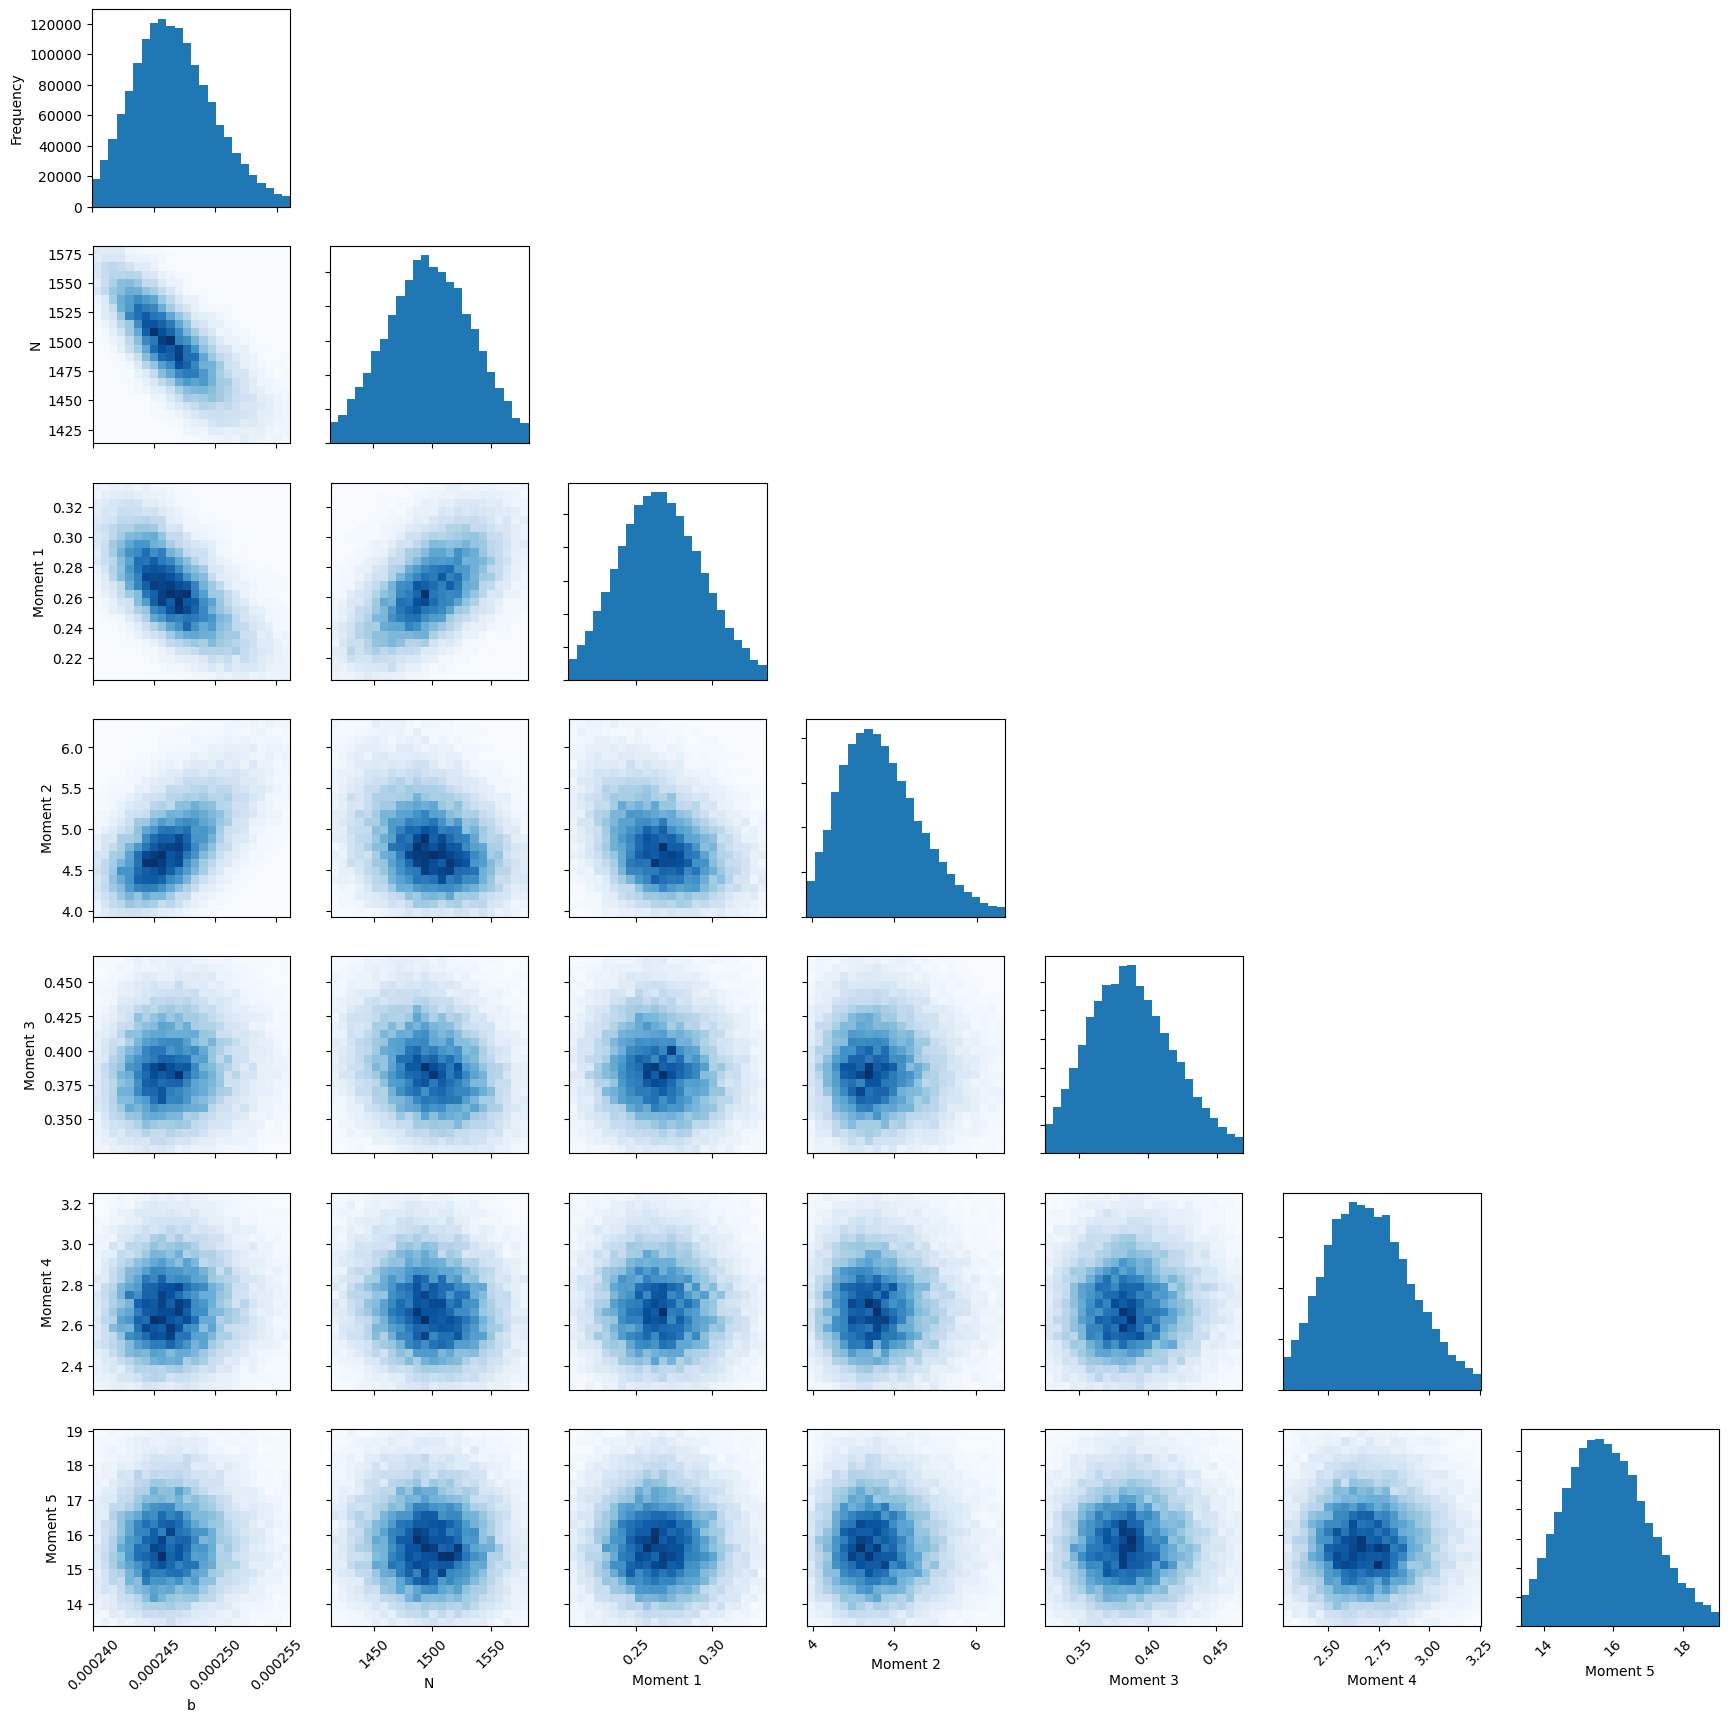

In [20]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[2.40508154e-04 1.53073316e+03 2.96225092e-01 4.73315712e+00
 3.90748058e-01 2.47440016e+00 1.39000261e+01]


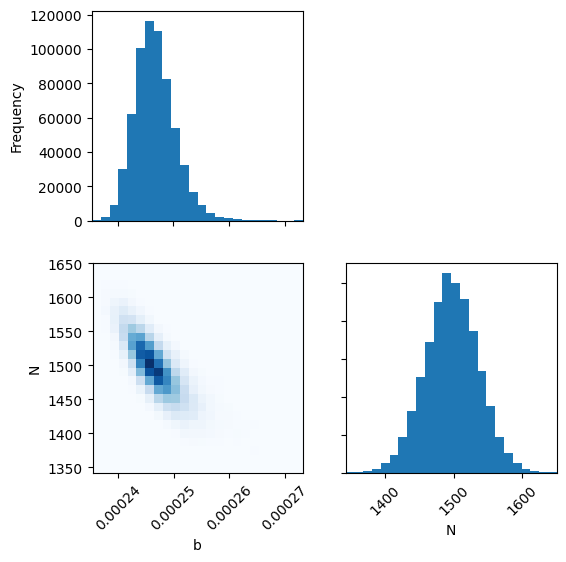

In [21]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1271.20  0.14
N         1497.00  38.59   1421.83  1471.62  1496.89  1522.92  1573.18  1.00    1624.35  0.17
Moment 1  0.27     0.03    0.21     0.25     0.27     0.29     0.33     1.00    1980.33  0.21
Moment 2  4.87     0.55    4.00     4.48     4.79     5.17     6.14     1.00    1934.99  0.21
Moment 3  0.39     0.03    0.33     0.36     0.39     0.41     0.46     1.00    4489.86  0.48
Moment 4  2.71     0.22    2.32     2.55     2.69     2.85     3.19     1.00    4780.22  0.51
Moment 5  15.85    1.31    13.54    14.94    15.75    16.64    18.70    1.00    4726.54  0.51


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000247  3.67e-06  0.000241  0.000244  0.000246  0.000249  0.000255  1       1.27e+03  0.136
N         1.5e+03   38.6      1.42e+03  1.47e+03  1.5e+03   1.52e+03  1.57e+03  1       1.62e+03  0.174
Moment 1  0.266     0.0296    0.212     0.246     0.265     0.285     0.328     1       1.98e+03  0.212
Moment 2  4.87      0.55      4         4.48      4.79      5.17      6.14      1       1.93e+03  0.207
Moment 3  0.389     0.0333    0.33      0.365     0.386     0.41      0.461     1       4.49e+03  0.481
Moment 4  2.71      0.224     2.32      2.55      2.69      2.85      3.19      1       4.78e+03  0.512
Moment 5  15.8      1.31      13.5      14.9      15.8      16.6      18.7      1       4.73e+03  0.506


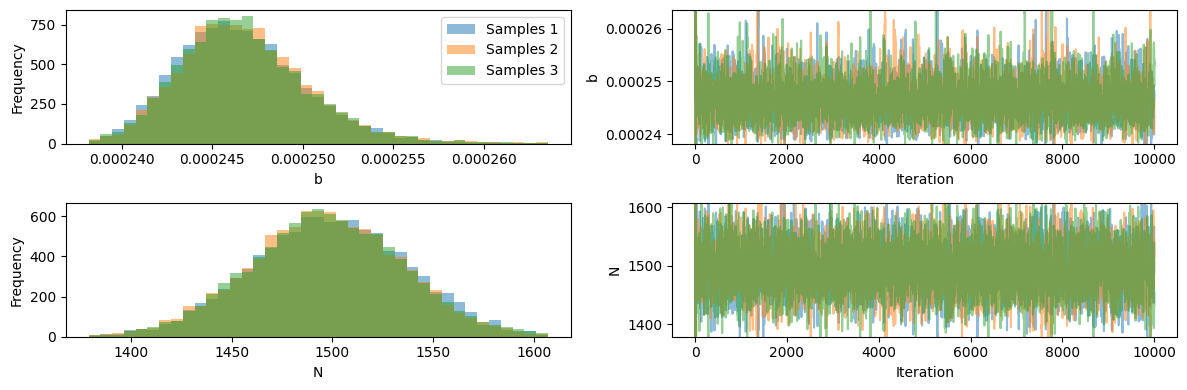

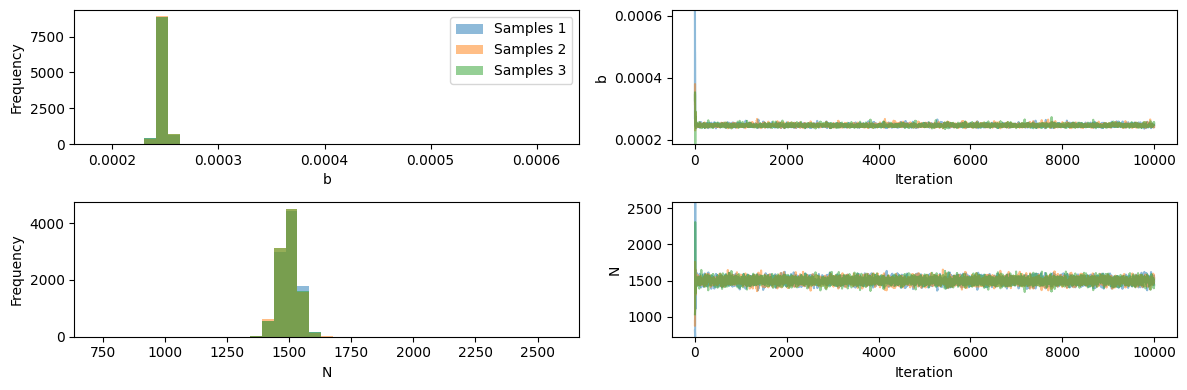

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()